# Air Temperature Forecasting with LSTM

Oleh: Crista Livia Budiman

In [44]:
# !pip install tensorflow

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import warnings
import random
warnings.filterwarnings('ignore')

SEED_VALUE = 42
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [46]:
df = pd.read_csv("AP004.csv")

# **Data Preparation**

EDA yang perlu dilakukan:
1. Memeriksa informasi dasar dalam dataset
2. Cek missing values dan outliers
4. Visualisasi time series
5. Cek korelasi antar fitur

In [47]:
df.shape

(48802, 25)

Dataset awal terdiri atas 48,802 baris dan 25 kolom.

In [48]:
df

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-09-05 14:00:00,2017-09-05 15:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,...,30.30,69.00,3.20,213.00,372.00,747.00,0.10,33.80,0.00,0.50
1,2017-09-05 15:00:00,2017-09-05 16:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,...,30.00,70.50,4.10,140.00,290.75,747.25,0.05,32.22,0.00,0.48
2,2017-09-05 16:00:00,2017-09-05 17:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,...,29.85,88.00,2.82,174.75,300.25,747.00,0.00,28.30,0.93,0.53
3,2017-09-05 17:00:00,2017-09-05 18:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,...,29.25,88.75,1.72,231.50,225.50,747.75,0.00,28.77,0.00,1.85
4,2017-09-05 18:00:00,2017-09-05 19:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,...,28.05,88.50,1.97,105.25,11.25,748.25,0.00,28.25,0.00,2.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48797,2023-03-31 19:00:00,2023-03-31 20:00:00,10.75,29.25,2.98,8.18,6.77,6.10,8.90,0.50,...,NaN,67.00,4.97,186.25,3.00,751.75,0.06,33.58,0.00,0.53
48798,2023-03-31 20:00:00,2023-03-31 21:00:00,9.75,28.75,3.15,9.88,7.77,6.10,10.43,0.68,...,NaN,70.75,3.70,162.75,3.00,752.00,0.07,32.52,0.00,0.50
48799,2023-03-31 21:00:00,2023-03-31 22:00:00,16.75,33.75,2.95,14.32,10.00,7.90,12.17,0.86,...,NaN,73.25,3.33,128.75,3.00,752.50,0.07,31.20,0.00,0.75
48800,2023-03-31 22:00:00,2023-03-31 23:00:00,12.75,34.75,1.98,13.60,8.80,10.12,18.57,0.76,...,NaN,75.00,3.55,120.25,3.50,753.00,0.06,30.85,0.00,0.70


Berdasarkan data di atas, dapat diketahui bahwa dataset ini merupakan hasil observasi per jam, karena selisih waktu antara kolom 'From Date' dan 'To Date' hanya 1 jam, di mana hal tersebut tidak akan memberikan kontribusi yang signifikan terhadap proses prediksi. Oleh karena itu, diputuskan untuk drop kolom 'To Date' dari dataset.

In [49]:
df.drop(columns='To Date', inplace=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48802 entries, 0 to 48801
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   From Date            48802 non-null  object 
 1   PM2.5 (ug/m3)        46344 non-null  float64
 2   PM10 (ug/m3)         46917 non-null  float64
 3   NO (ug/m3)           47244 non-null  float64
 4   NO2 (ug/m3)          47224 non-null  float64
 5   NOx (ppb)            46628 non-null  float64
 6   NH3 (ug/m3)          47140 non-null  float64
 7   SO2 (ug/m3)          46649 non-null  float64
 8   CO (mg/m3)           46387 non-null  float64
 9   Ozone (ug/m3)        47156 non-null  float64
 10  Benzene (ug/m3)      46914 non-null  float64
 11  Toluene (ug/m3)      46908 non-null  float64
 12  Eth-Benzene (ug/m3)  23988 non-null  float64
 13  MP-Xylene (ug/m3)    39256 non-null  float64
 14  Temp (degree C)      21599 non-null  float64
 15  RH (%)               47364 non-null 

In [51]:
df['From Date'] = pd.to_datetime(df['From Date'])

In [52]:
df['hour'] = df['From Date'].dt.hour
df['month'] = df['From Date'].dt.month

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df.drop(['hour', 'month'], axis=1, inplace=True)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48802 entries, 0 to 48801
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   From Date            48802 non-null  datetime64[ns]
 1   PM2.5 (ug/m3)        46344 non-null  float64       
 2   PM10 (ug/m3)         46917 non-null  float64       
 3   NO (ug/m3)           47244 non-null  float64       
 4   NO2 (ug/m3)          47224 non-null  float64       
 5   NOx (ppb)            46628 non-null  float64       
 6   NH3 (ug/m3)          47140 non-null  float64       
 7   SO2 (ug/m3)          46649 non-null  float64       
 8   CO (mg/m3)           46387 non-null  float64       
 9   Ozone (ug/m3)        47156 non-null  float64       
 10  Benzene (ug/m3)      46914 non-null  float64       
 11  Toluene (ug/m3)      46908 non-null  float64       
 12  Eth-Benzene (ug/m3)  23988 non-null  float64       
 13  MP-Xylene (ug/m3)    39256 non-

In [54]:
df.set_index('From Date', inplace=True)

In [55]:
df = df.dropna(subset=['AT (degree C)'])

In [56]:
df.duplicated().sum()

np.int64(0)

## Check Missing Values

In [57]:
df.isna().sum()

,0
PM2.5 (ug/m3),1042
PM10 (ug/m3),470
NO (ug/m3),143
NO2 (ug/m3),164
NOx (ppb),760
NH3 (ug/m3),240
SO2 (ug/m3),740
CO (mg/m3),999
Ozone (ug/m3),232
Benzene (ug/m3),468


Kolom 'Temp (degree C)' memiliki lebih dari 50% missing values (27.203), sehingga dianggap kurang ideal untuk dipertahankan dalam dataset. Selain itu, karena tujuan analisis adalah memprediksi kualitas udara di suatu wilayah (AT), kolom ini dinilai tidak memberikan pengaruh yang signifikan terhadap proses prediksi sehingga diputuskan untuk drop kolom 'Temp' dari dataset.

Demikian pula, kolom 'Eth-Benzene (ug/m3)' juga memiliki lebih dari 50% missing value (24.814). Terlebih lagi, sudah ada kolom 'Benzene (ug/m3)' yang dianggap lebih relevan untuk prediksi dengan jumlah missing value yang jauh lebih sedikit (1.888), sehingga masih dapat diatasi dengan imputasi. Maka dari itu, diputuskan untuk juga drop kolom 'Eth-Benzene (ug/m3)' dari dataset.

Kolom ketiga dengan jumlah missing values terbanyak adalah 'MP-Xylene (ug/m3)', yaitu sebanyak 9546 missing values. Meskipun tidak sebanyak 2 kolom sebelumnya, jumlah ini hampir mencakup 20% dari jumlah baris sehingga perlu dipertambangkan apakah sebaiknya di drop atau imputasi. Namun setelah mengetahui bahwa terdapat kolom 'Xylene (ug/m3)' yang mencakup Xylene secara keseluruhan dan jumlah missing values yang jauh lebih sedikit (1.727) maka diputuskan untuk juga drop kolom 'MP-Xylene (ug/m3)' untuk mencegah terjadinya overfitting karena model mempelajari pola berulang dari dua fitur yang  mirip.

Untuk kolom lain, tahap imputasi akan dilakukan setelah splitting

In [58]:
df = df.drop(columns=['Temp (degree C)', 'Eth-Benzene (ug/m3)', 'MP-Xylene (ug/m3)'])

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47286 entries, 2017-09-05 14:00:00 to 2023-03-31 23:00:00
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PM2.5 (ug/m3)    46244 non-null  float64
 1   PM10 (ug/m3)     46816 non-null  float64
 2   NO (ug/m3)       47143 non-null  float64
 3   NO2 (ug/m3)      47122 non-null  float64
 4   NOx (ppb)        46526 non-null  float64
 5   NH3 (ug/m3)      47046 non-null  float64
 6   SO2 (ug/m3)      46546 non-null  float64
 7   CO (mg/m3)       46287 non-null  float64
 8   Ozone (ug/m3)    47054 non-null  float64
 9   Benzene (ug/m3)  46818 non-null  float64
 10  Toluene (ug/m3)  46813 non-null  float64
 11  RH (%)           47275 non-null  float64
 12  WS (m/s)         47285 non-null  float64
 13  WD (degree)      47283 non-null  float64
 14  SR (W/mt2)       47057 non-null  float64
 15  BP (mmHg)        47284 non-null  float64
 16  VWS (m/s)        46934 

## Visualisasi Time Series

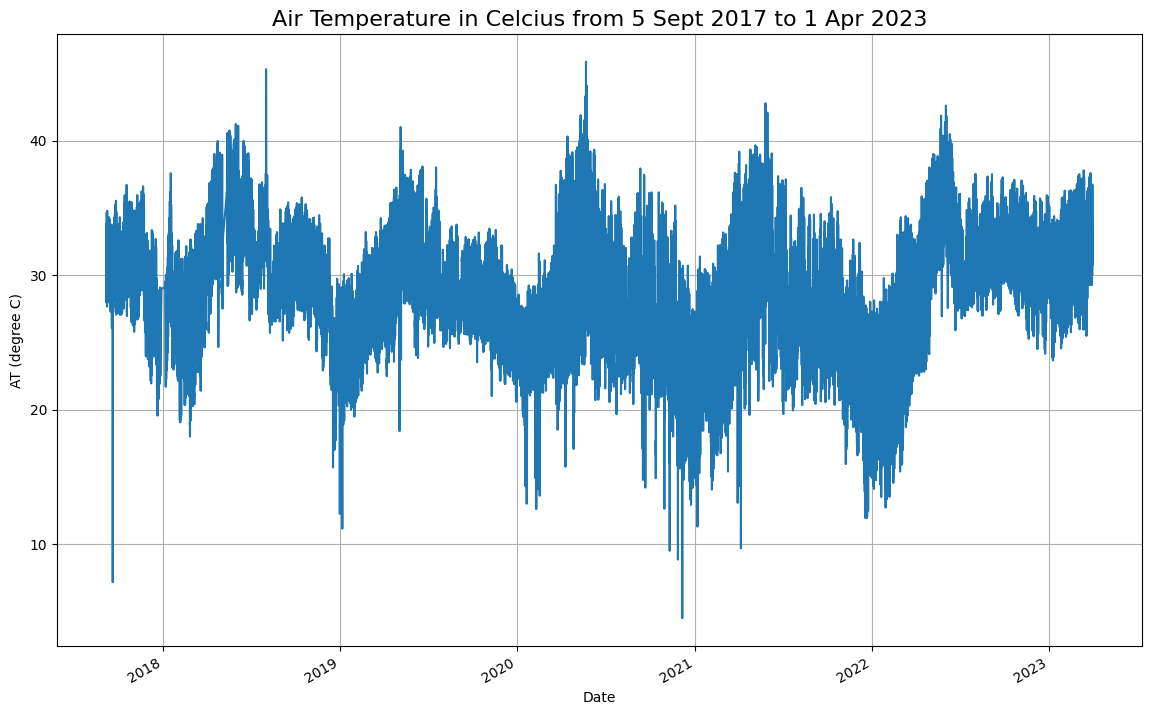

In [60]:
df['AT (degree C)'].plot(figsize=(14, 9))
plt.title('Air Temperature in Celcius from 5 Sept 2017 to 1 Apr 2023',fontsize=16)
plt.xlabel('Date')
plt.ylabel('AT (degree C)')
plt.grid(True)
plt.show()

Dari plot tersebut, dapat diperoleh beberapa informasi yaitu:
* Grafik terlihat naik turun secara berkala.
* Terlihat ada fluktuasi ekstrim pada awal yang kemungkinan besar disebabkan oleh anomali cuaca atau kesalahan sensor.
* Tidak terlihat peningkatan atau penurunan suhu yang signfikan

Informasi ini penting untuk diketahui karena dapat membantu dalam memahami karakteristik data secara menyeluruh sebelum digunakan untuk pemodelan. Dalam membuat model LSTM, pemahaman terhadap pola musiman dan urutan waktu sangat diperlukan agar model dapat belajar secara optimal. Selain itu, deteksi awal terhadap outlier atau anomali juga sangat penting agar data yang digunakan bersih dan tidak mengganggu performa model.

## Check Outliers

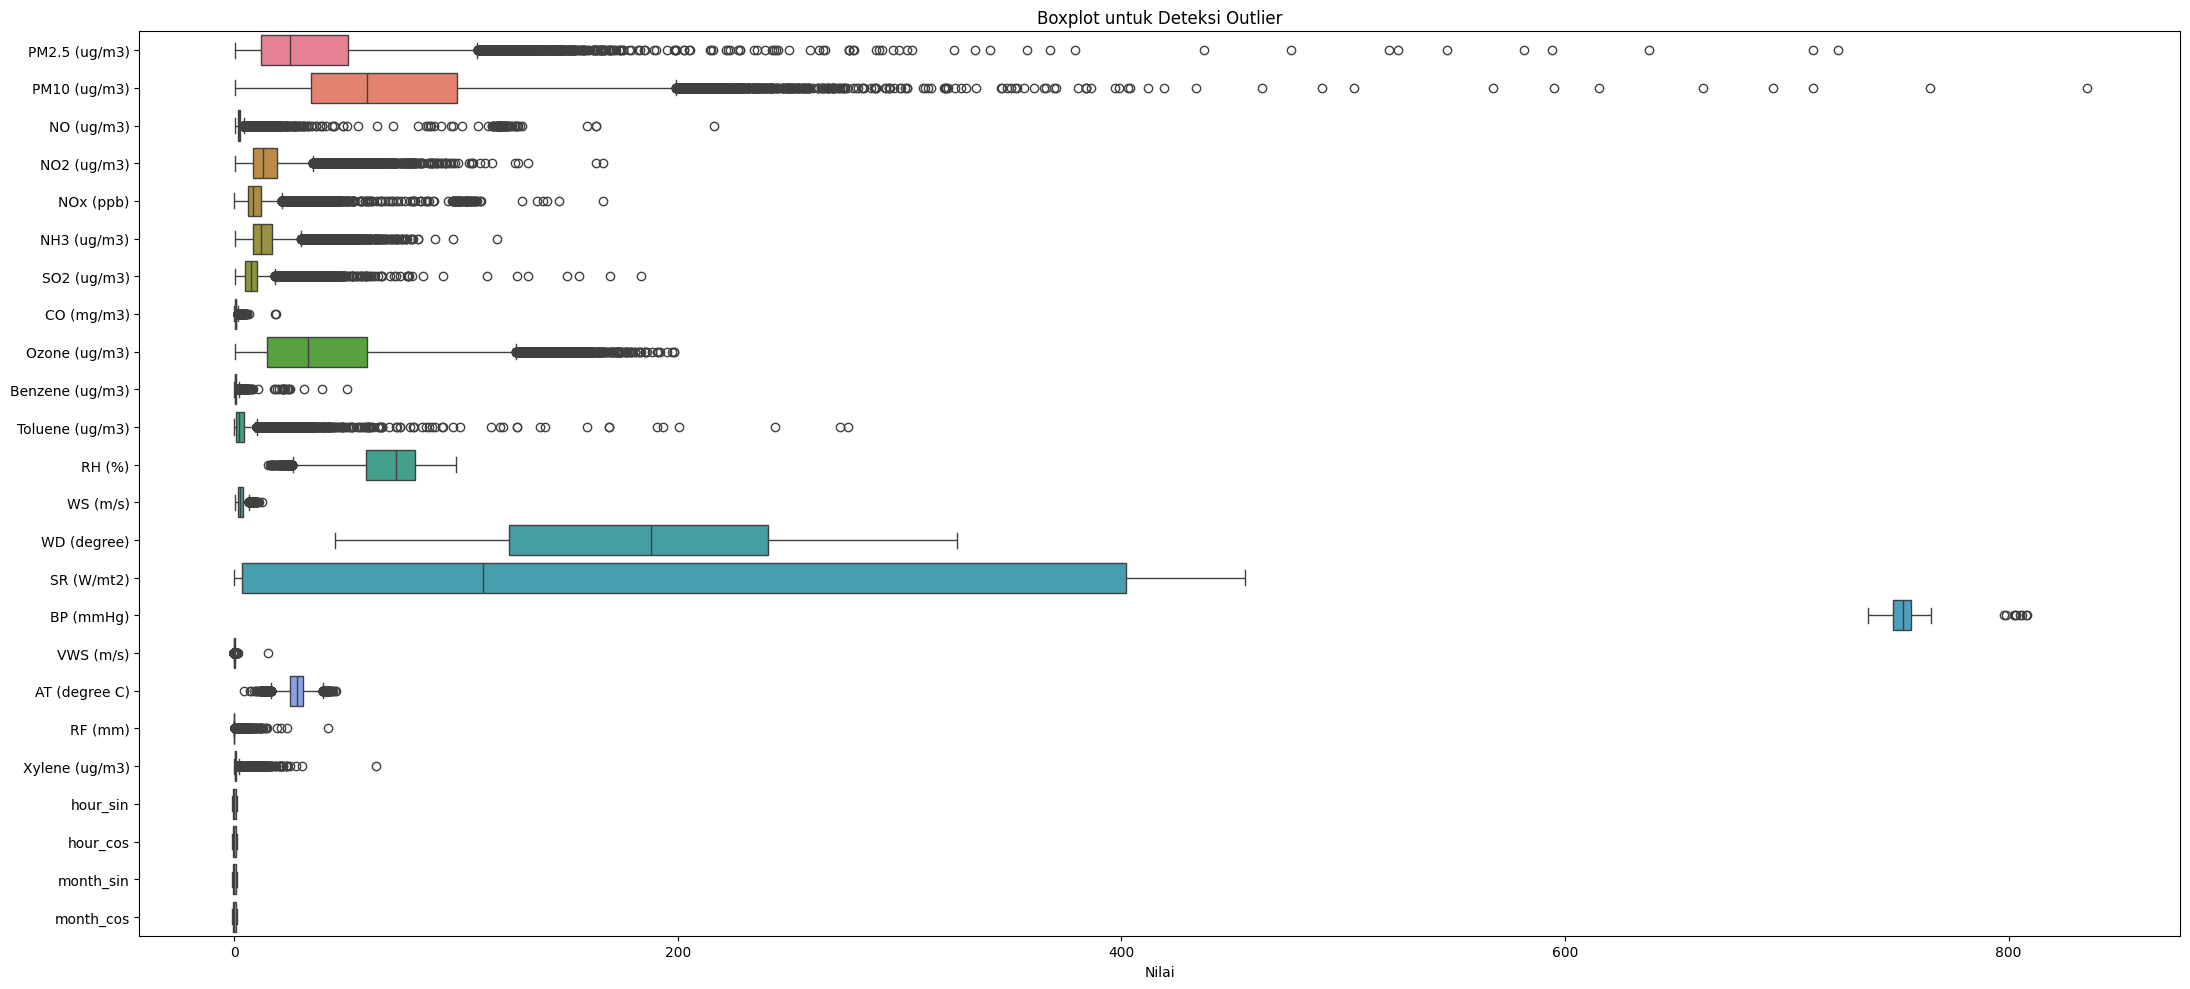

In [61]:
plt.figure(figsize=(22, 10))
sns.boxplot(data=df, orient="h")
plt.title("Boxplot untuk Deteksi Outlier")
plt.xlabel("Nilai")
plt.tight_layout()
plt.show()

In [62]:
df.describe()

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3),hour_sin,hour_cos,month_sin,month_cos
count,46244.000000,46816.000000,47143.000000,47122.000000,46526.000000,47046.000000,46546.000000,46287.000000,47054.000000,46818.000000,...,47057.000000,47284.000000,46934.000000,47286.000000,47261.000000,46825.000000,47286.000000,4.728600e+04,4.728600e+04,4.728600e+04
mean,34.771344,71.527326,2.510027,15.263188,10.014174,13.378615,8.496972,0.693494,40.916409,0.570073,...,193.882919,752.026727,0.006203,28.083312,0.038063,0.730497,-0.003820,-8.879537e-04,-1.101989e-02,5.121119e-02
std,30.767378,48.288656,5.063881,10.339324,7.148938,7.852680,6.089941,0.437132,32.660771,0.800491,...,191.875732,5.046977,0.092676,4.458718,0.445882,1.299648,0.706906,7.073118e-01,7.120878e-01,7.001486e-01
min,0.250000,0.250000,0.030000,0.100000,0.000000,0.100000,0.100000,0.000000,0.200000,0.000000,...,0.000000,736.500000,-0.280000,4.500000,0.000000,0.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,12.000000,34.500000,1.450000,8.430000,6.000000,8.200000,4.920000,0.430000,14.700000,0.100000,...,3.500000,748.000000,-0.020000,25.170000,0.000000,0.100000,-0.707107,-7.071068e-01,-8.660254e-01,-5.000000e-01
50%,25.000000,59.670000,1.900000,12.780000,8.450000,11.900000,7.250000,0.630000,33.200000,0.350000,...,112.000000,752.500000,0.000000,28.270000,0.000000,0.330000,0.000000,-1.836970e-16,-2.449294e-16,6.123234e-17
75%,51.000000,100.330000,2.600000,19.270000,12.150000,17.000000,10.350000,0.880000,59.665000,0.830000,...,402.250000,756.000000,0.040000,31.050000,0.000000,0.800000,0.707107,7.071068e-01,5.000000e-01,8.660254e-01
max,723.000000,835.500000,216.170000,166.250000,166.000000,118.250000,183.300000,18.690000,198.400000,50.900000,...,455.750000,808.250000,15.000000,45.850000,42.200000,64.020000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


Melalui EDA ini, dapat diketahui bahwa terdapat beberapa kolom yang memiliki outliers ekstrim. Informasi ini penting untuk mengetahui metode scaling yang sesuai untuk dataset ini, yaitu Robust Scaler.

## Correlation Matrix Between Features

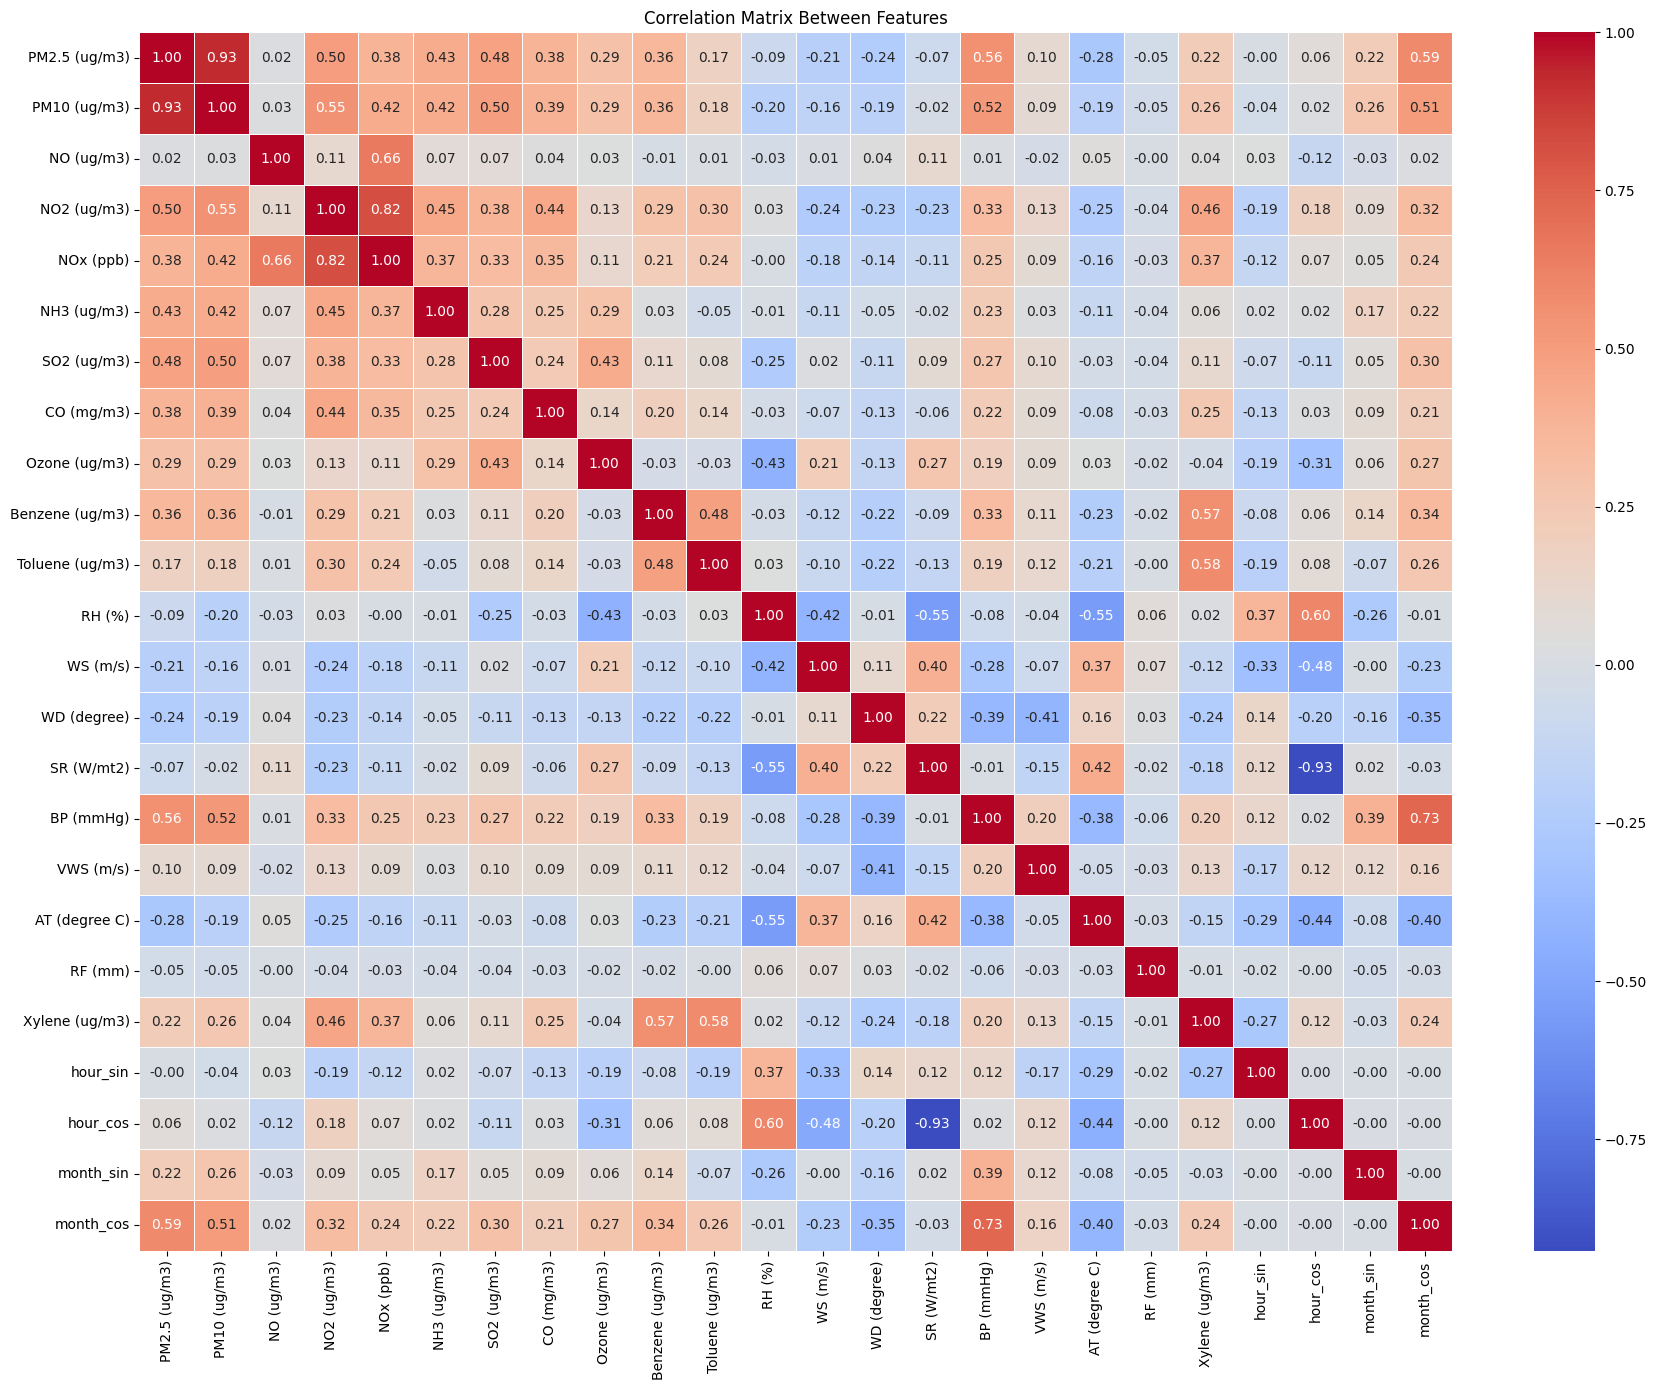

In [63]:
corr_matrix = df.corr()

plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Between Features')
plt.tight_layout()
plt.show()

Melalui correlation matrix, dapat diperoleh beberapa informasi yaitu:
* 'RH (%)' memiliki korelasi negatif terkuat terhadap AT (-0.55)
* 'SR (W/mt2)' memiliki korelasi positif terkuat terhadap AT (+0.42)
* 'SO2 (ug/m3)' dan 'RF (mm)' dengan korelasi terendah terhadap AT (-0.03)
* 'RF (mm)' tidak memiliki hubungan signifikan dengan fitur manapun karena nilai korelasinya sangat kecil, yaitu kurang dari -0.05 s/d +0.07

Informasi ini perlu diketahui agar dapat mengetahui korelasi antar fitur dengan target prediksi (AT), sehingga dapat membantu menghindari penggunaan fitur yang tidak memberikan kontribusi signifikan dalam modelling. Melalui informasi tersebut diputuskan untuk menghapus tiga kolom, yaitu 'SO2 (ug/m3)' dan 'RF (mm)' karena memiliki korelasi terendah terhadap target prediksi (AT).

In [64]:
df = df.drop(columns=['SO2 (ug/m3)','RF (mm)'])

In [65]:
df.columns

Index(['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
       'NOx (ppb)', 'NH3 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)',
       'Benzene (ug/m3)', 'Toluene (ug/m3)', 'RH (%)', 'WS (m/s)',
       'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'AT (degree C)',
       'Xylene (ug/m3)', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos'],
      dtype='object')

## Split Train Test Val

80% training, 10% validasi, dan 10% testing

In [66]:
train, val, test = np.split(
    df,
     [int(0.8 * len(df)),
      int(0.9 * len(df))])

print(f"Train: {len(train)}")
print(f"Val: {len(val)}")
print(f"Test: {len(test)}")

Train: 37828
Val: 4729
Test: 4729


## Handle Missing Values and Outliers

In [67]:
print("NULL in train:", np.isnan(train).sum().sum())
print("NULL in val:", np.isnan(val).sum().sum())
print("NULL in test:", np.isnan(test).sum().sum())

NULL in train: 5201
NULL in val: 483
NULL in test: 366


Metode imputasi yang digunakan adalah gabungan dari interpolasi liear dua arah dan metode fillna. Interpolasi linear memperkirakan nilai berdasarkan tren data di sekitar titik yang hilang, sedangkan fillna dengan metode forward-fill dan backward-fill digunakan sebagai pelengkap untuk mengisi nilai yang mungkin tidak terisi oleh interpolasi, terutama pada bagian awal atau akhir data. Oleh karena itu, metode ini sangat cocok karena dataset merupakan data time series yang sensitif terhadap urutan waktu.

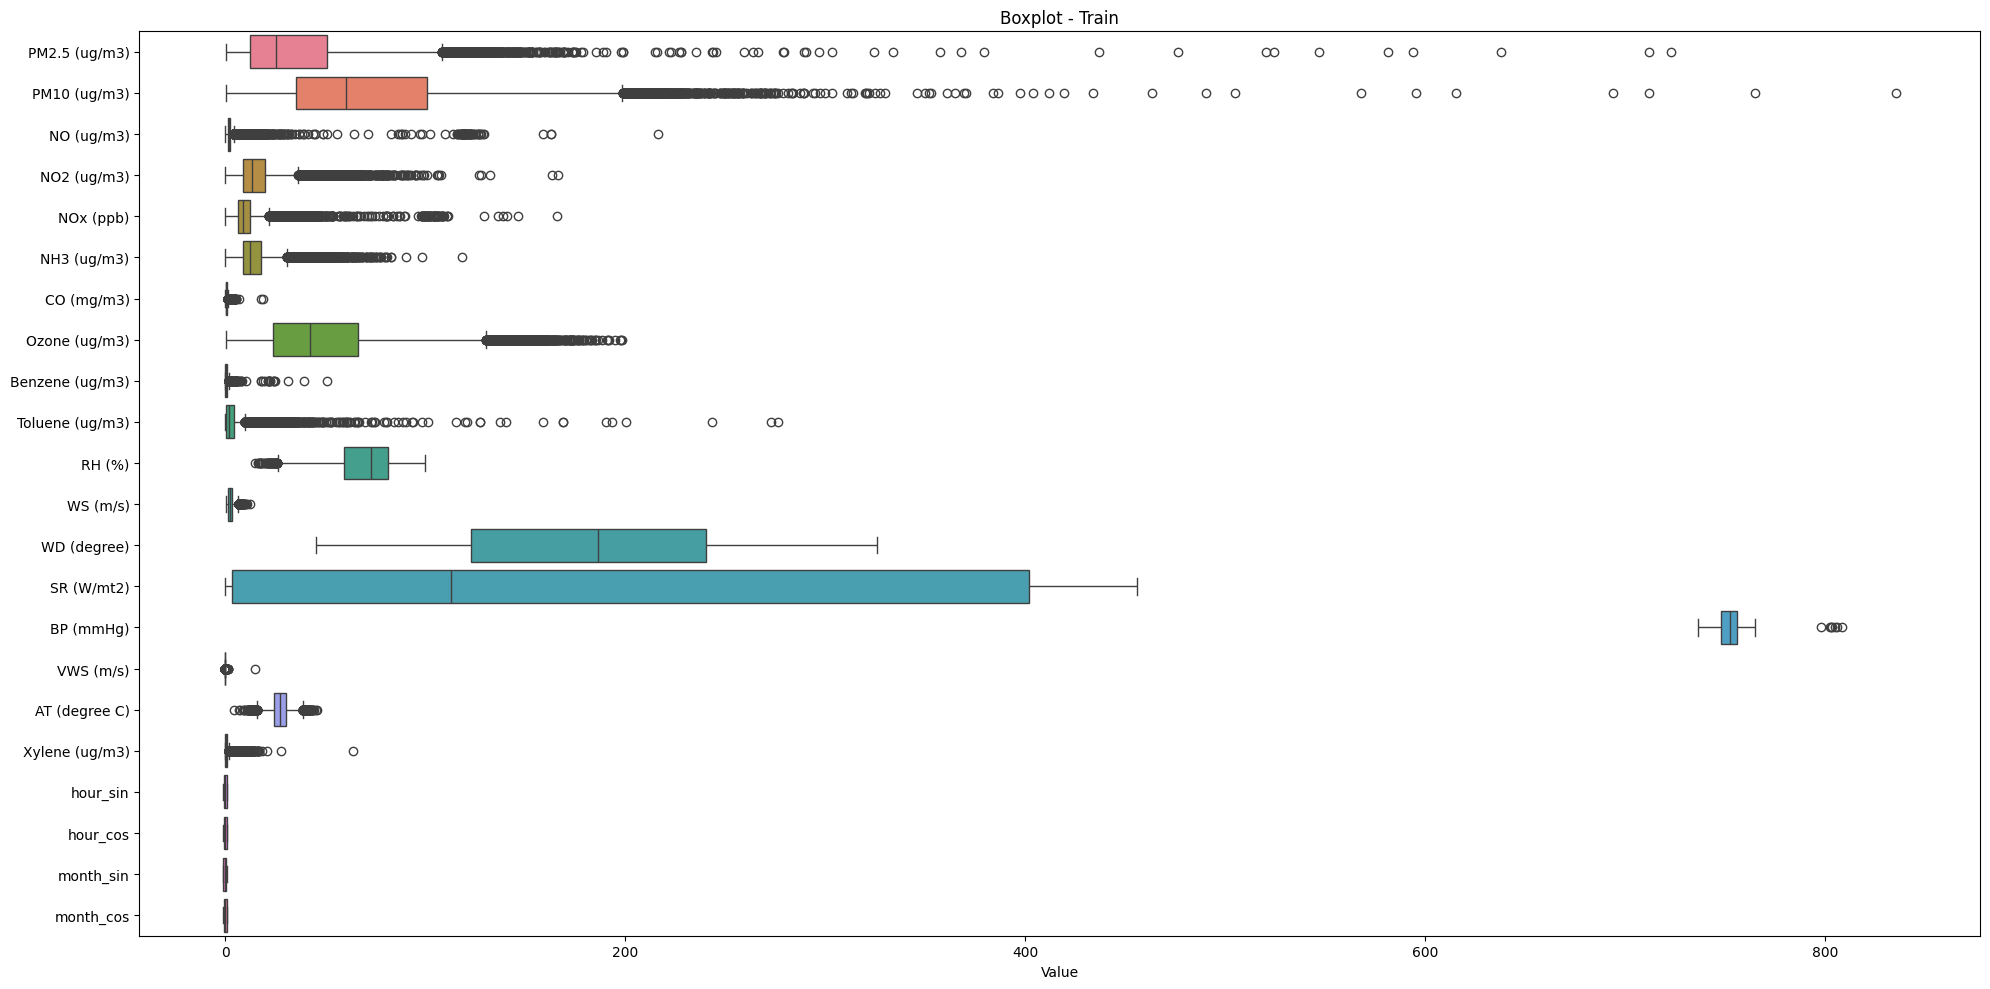

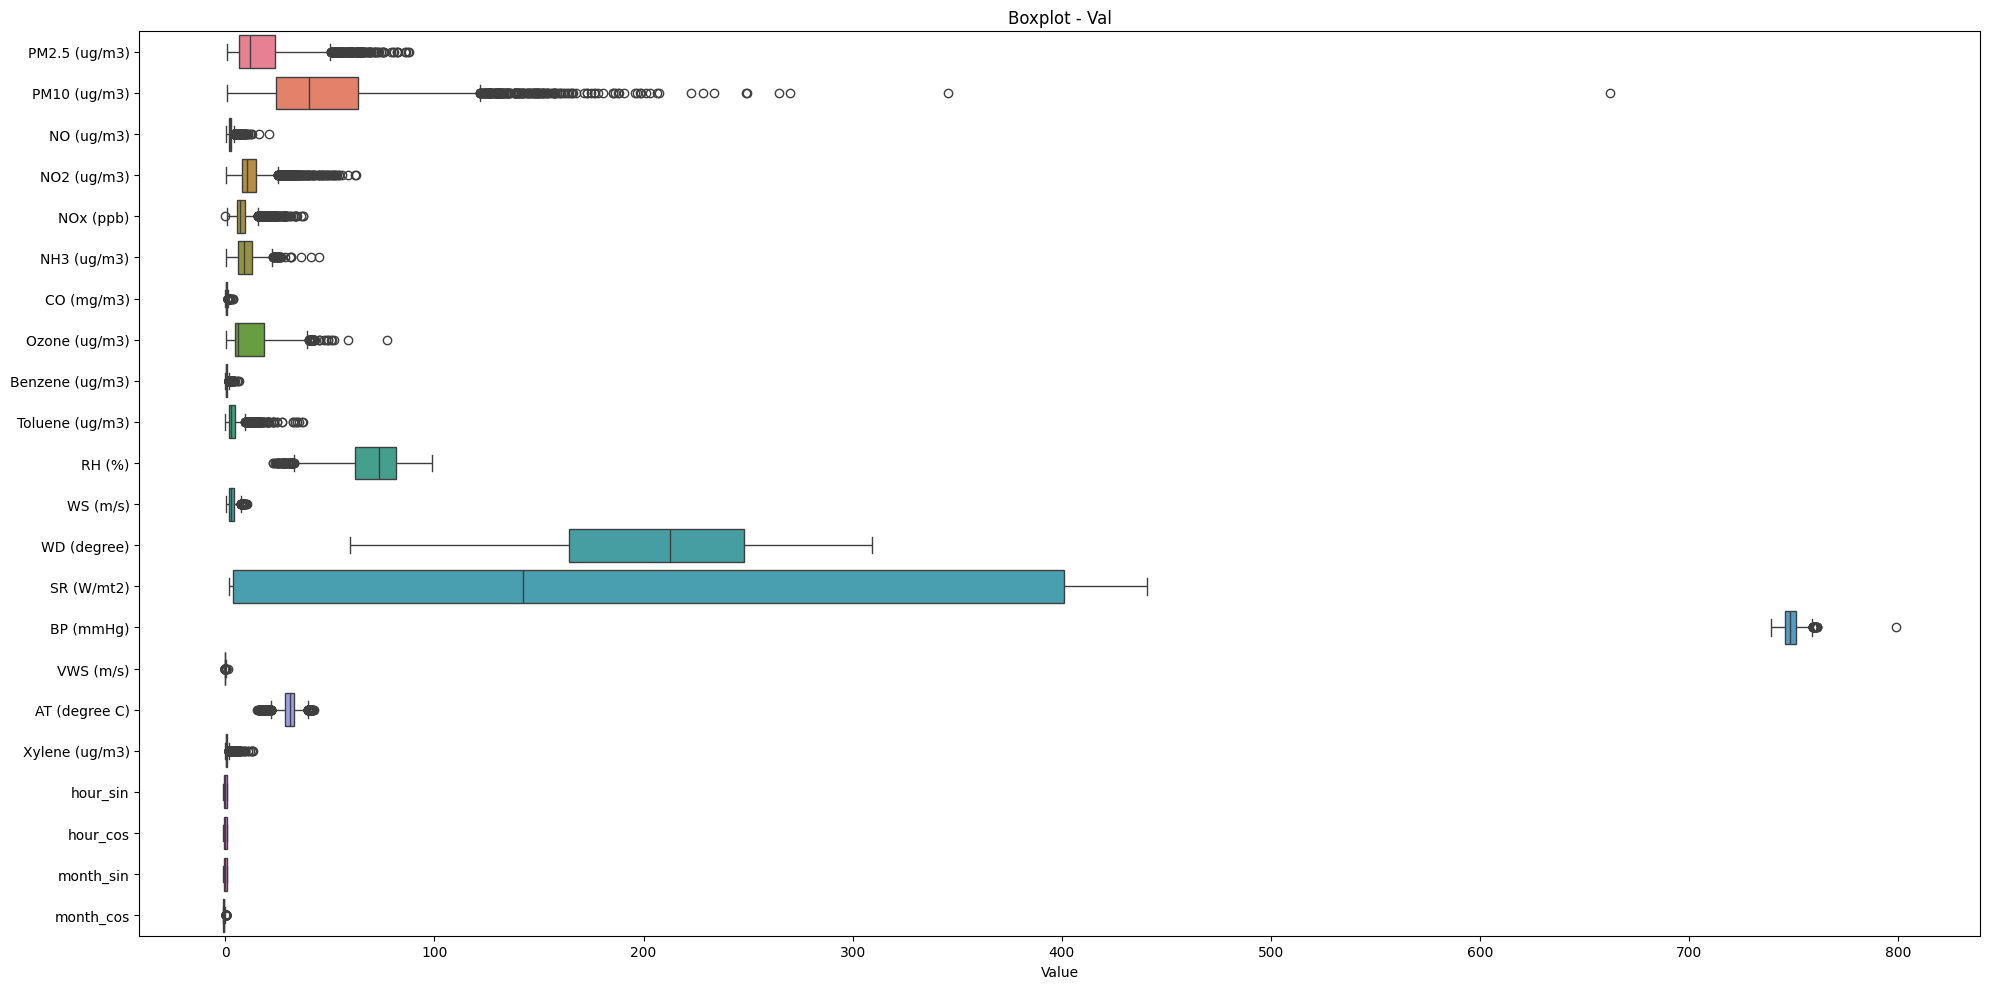

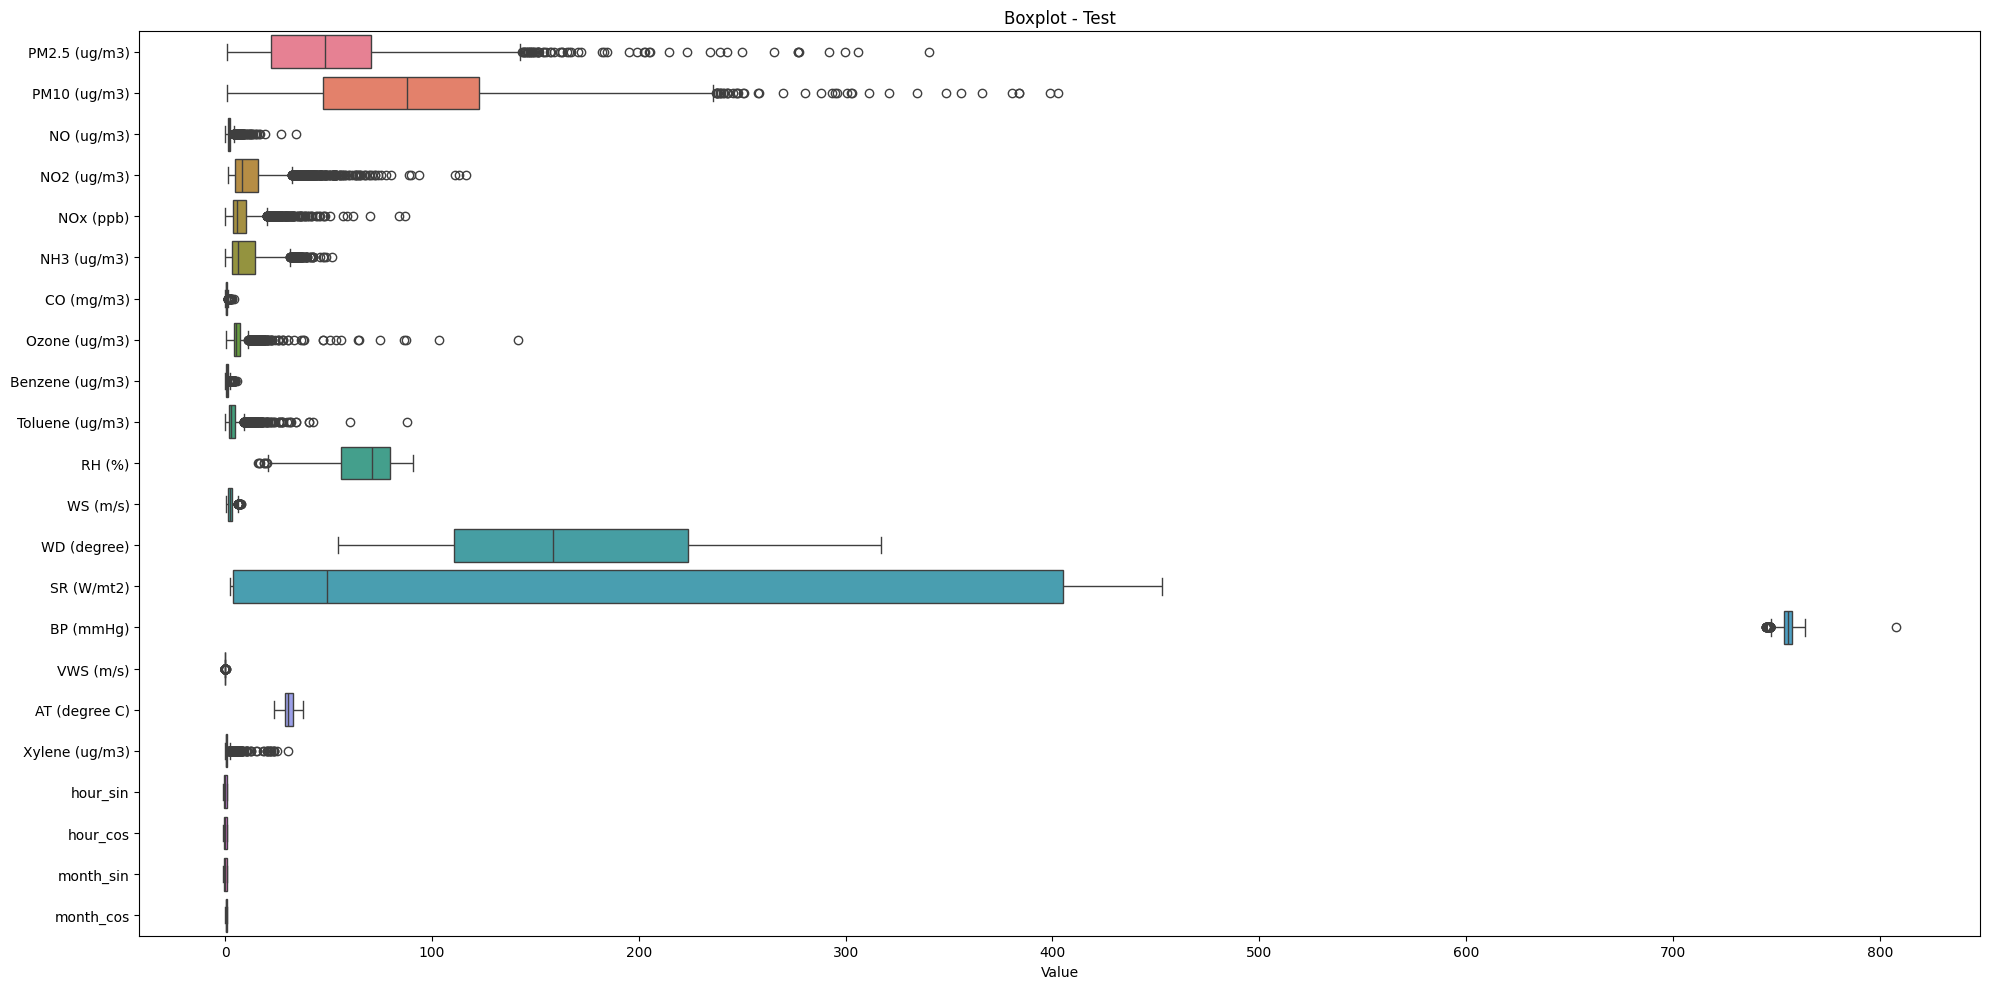

In [68]:
def plot_boxplots(df, title):
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=df, orient="h")
    plt.title(title)
    plt.xlabel("Value")
    plt.tight_layout()
    plt.show()

plot_boxplots(train, "Boxplot - Train")
plot_boxplots(val, "Boxplot - Val")
plot_boxplots(test, "Boxplot - Test")

In [69]:
def handle_outliers(df_subset):
    for col in df_subset.columns:
        if col == 'AT (degree C)':
            continue

        col_data = df_subset[col].dropna()
        if not col_data.empty:
            Q1 = col_data.quantile(0.25)
            Q3 = col_data.quantile(0.75)
            IQR = Q3 - Q1
            extreme_upper = Q3 + 10 * IQR

            df_subset[col] = df_subset[col].mask(df_subset[col] > extreme_upper)
            df_subset[col] = df_subset[col].interpolate(method='time')
            df_subset[col] = df_subset[col].fillna(method='ffill').fillna(method='bfill')
    return df_subset

train = handle_outliers(train)
val = handle_outliers(val)
test = handle_outliers(test)

In [70]:
print("NULL in train:", np.isnan(train).sum().sum())
print("NULL in val:", np.isnan(val).sum().sum())
print("NULL in test:", np.isnan(test).sum().sum())

NULL in train: 0
NULL in val: 0
NULL in test: 0


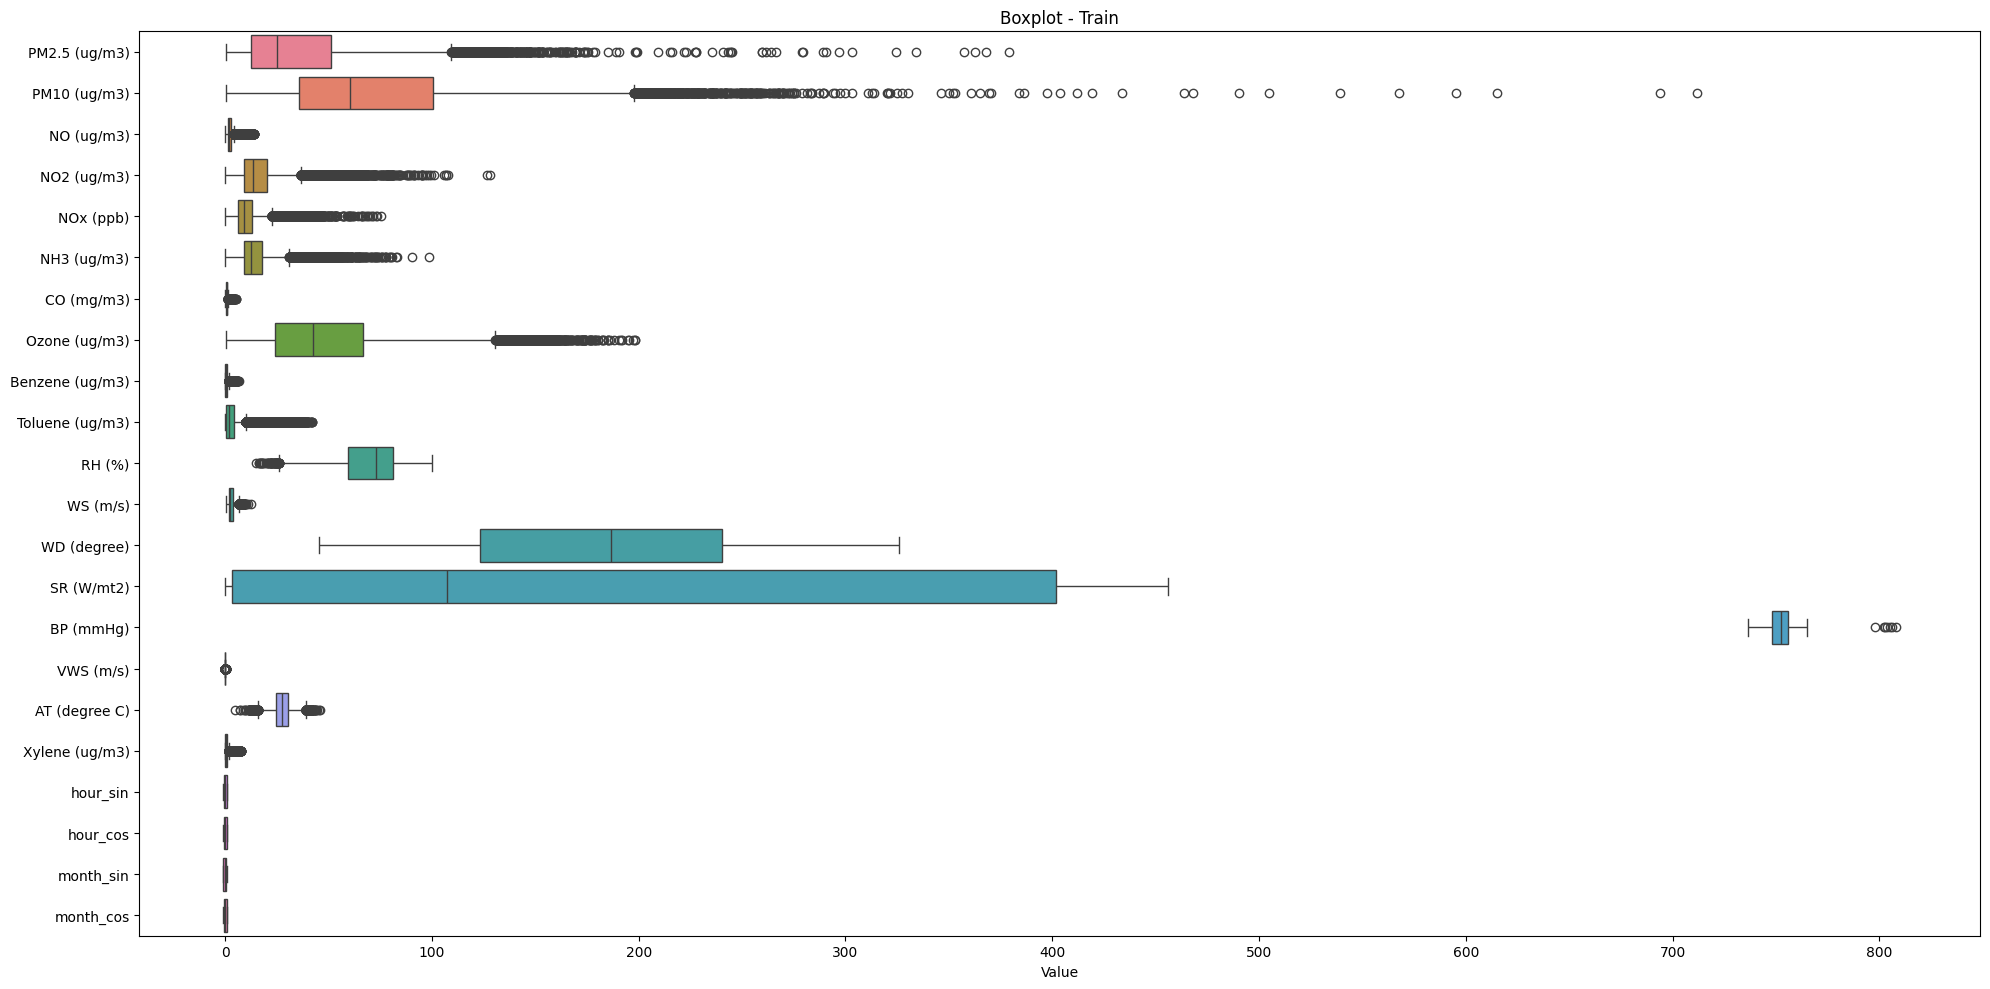

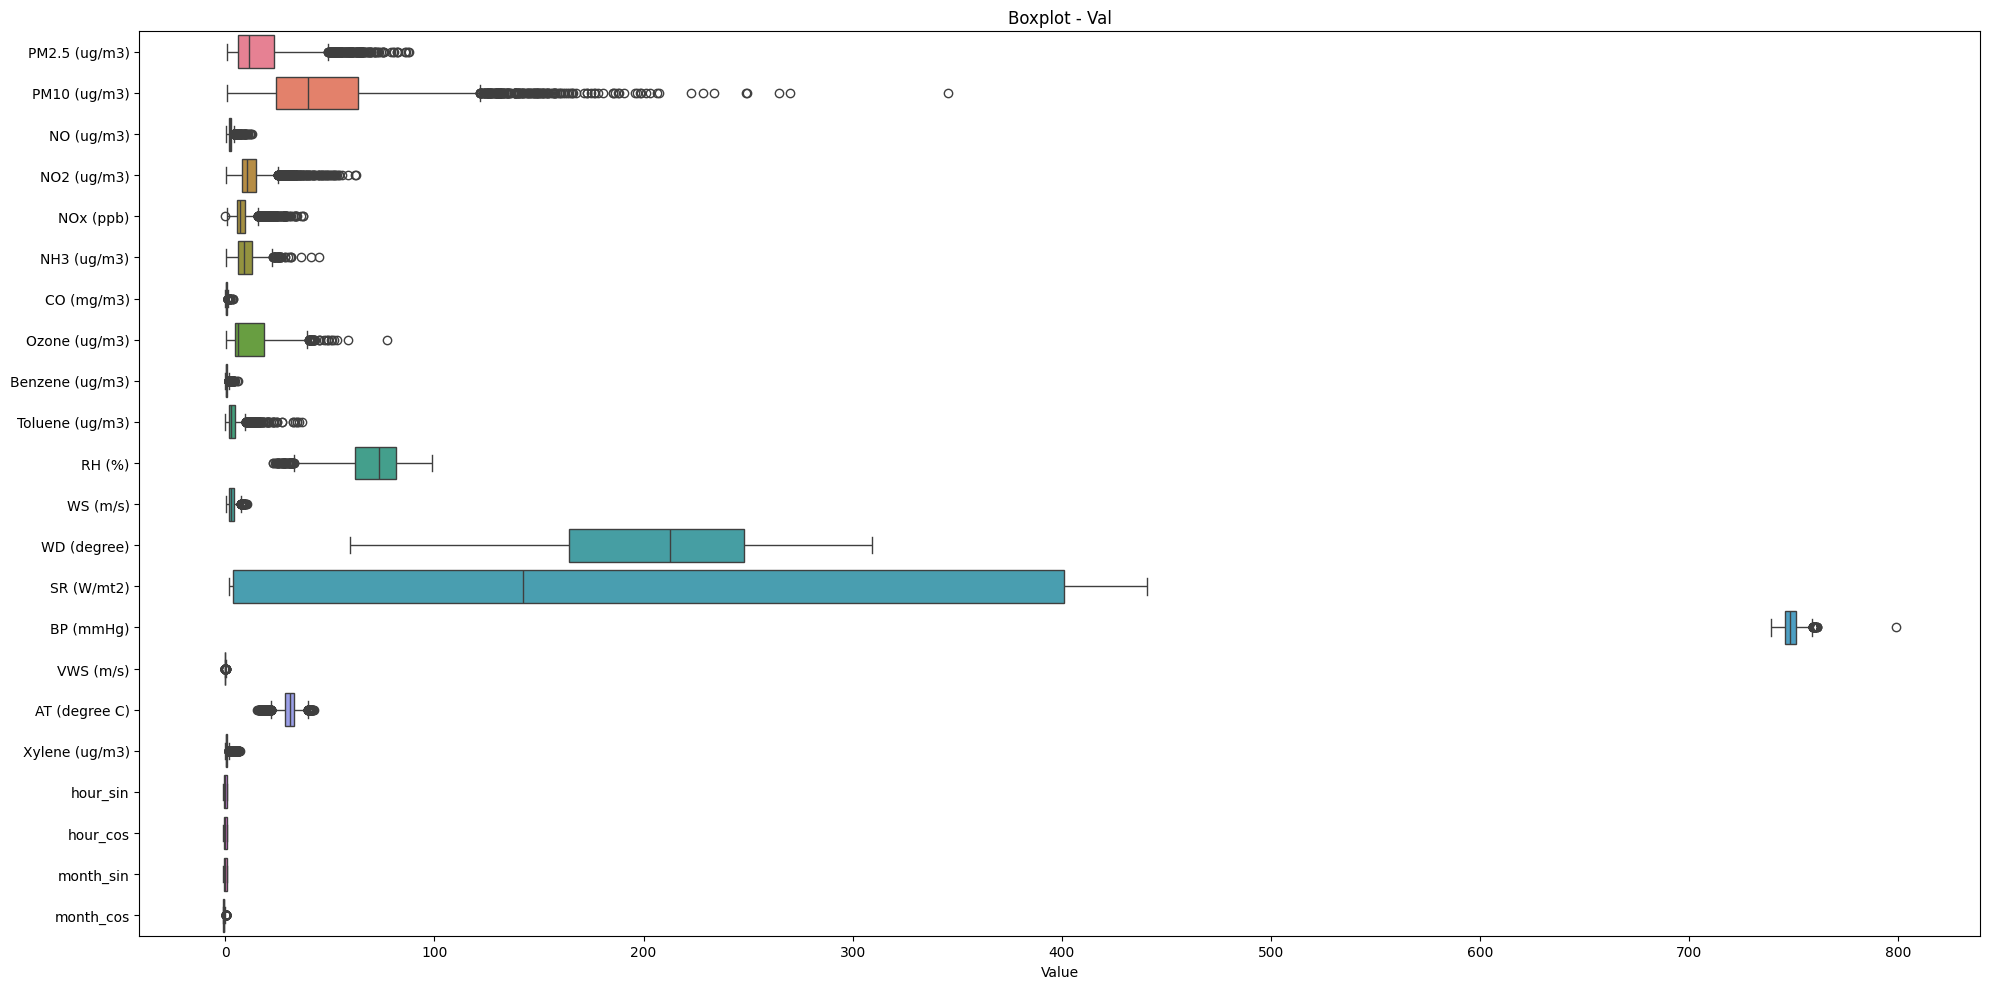

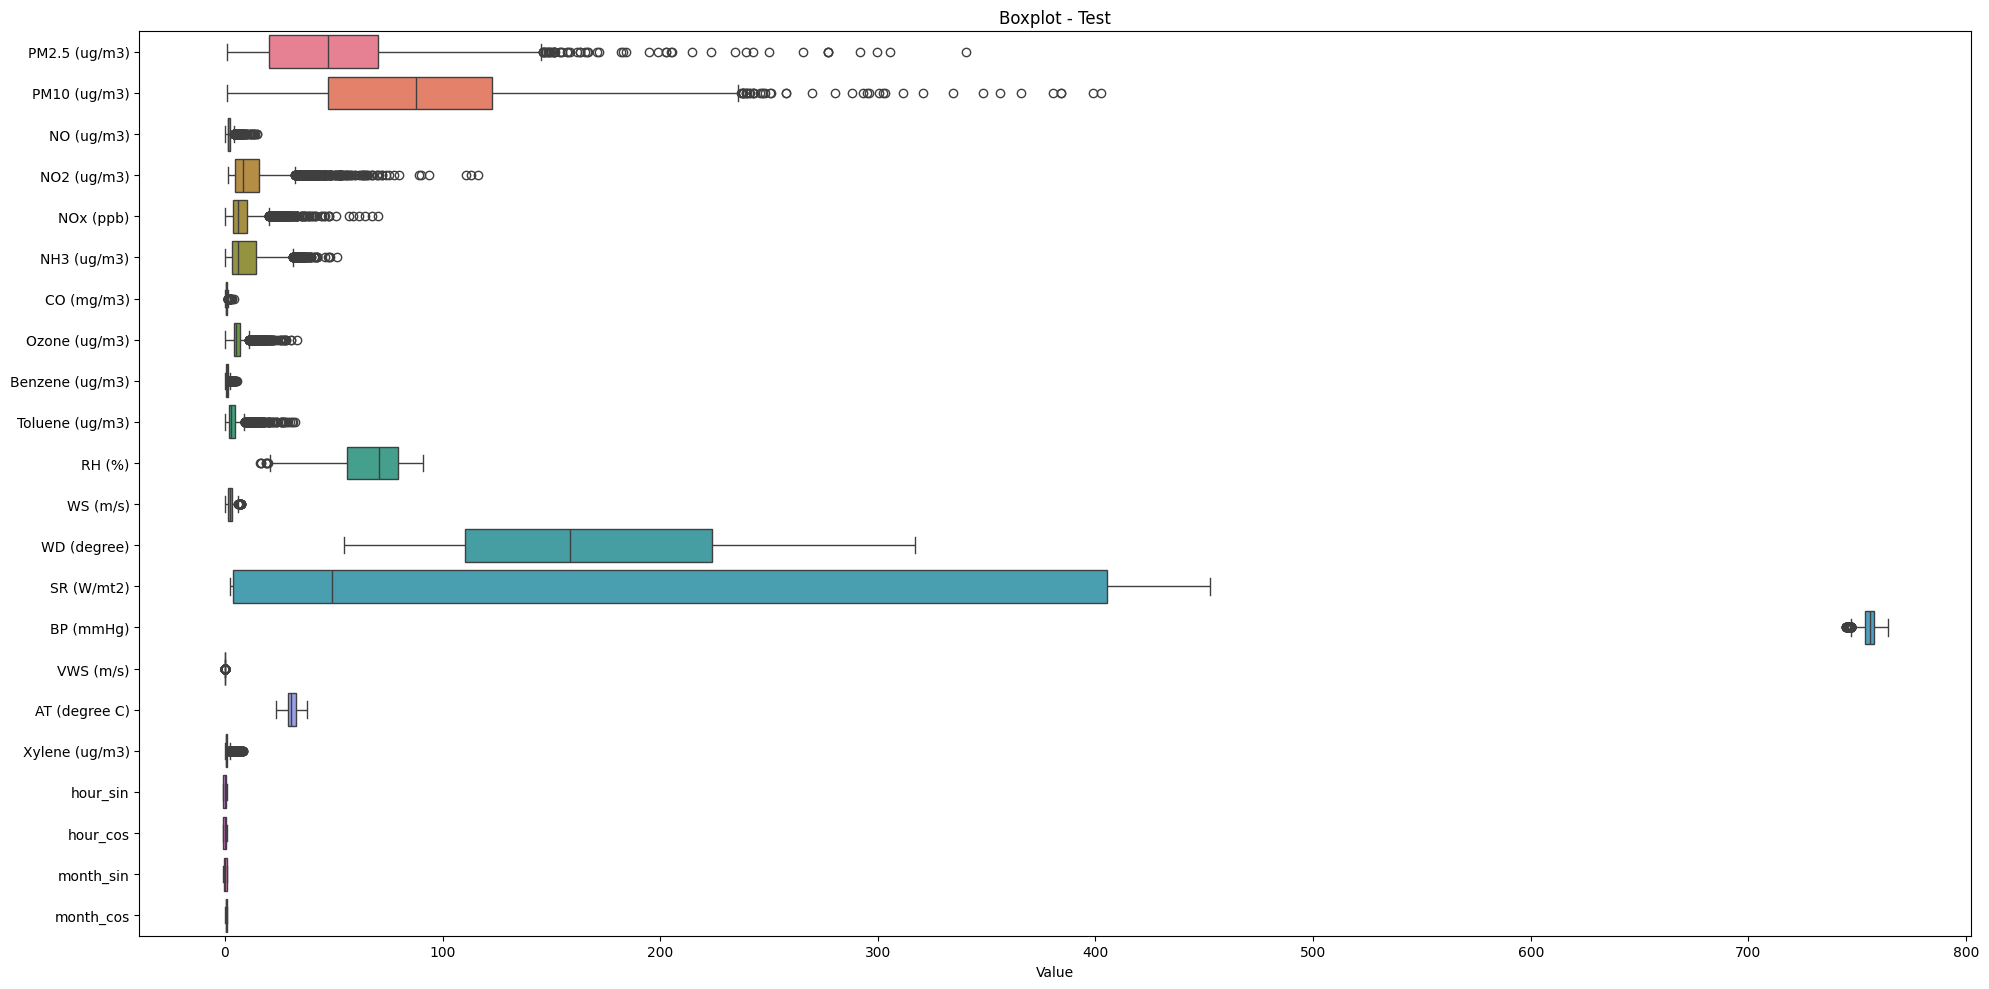

In [71]:
def plot_boxplots(df, title):
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=df, orient="h")
    plt.title(title)
    plt.xlabel("Value")
    plt.tight_layout()
    plt.show()

plot_boxplots(train, "Boxplot - Train")
plot_boxplots(val, "Boxplot - Val")
plot_boxplots(test, "Boxplot - Test")

outliers yang diimpute hanya extreme outliers saja

## Scaling

In [72]:
no_scale = train.columns[19:]
features_scaled = [col for col in train.columns if col not in no_scale]
target = 'AT (degree C)'

train_scale = train.copy()
val_scale = val.copy()
test_scale = test.copy()

In [73]:
rs_x = RobustScaler()
train_scale[features_scaled] = rs_x.fit_transform(train_scale[features_scaled])
val_scale[features_scaled] = rs_x.transform(val_scale[features_scaled])
test_scale[features_scaled] = rs_x.transform(test_scale[features_scaled])

rs_y = RobustScaler()
train_scale[[target]] = rs_y.fit_transform(train_scale[[target]])
val_scale[[target]] = rs_y.transform(val_scale[[target]])
test_scale[[target]] = rs_y.transform(test_scale[[target]])

In [74]:
train_df = pd.DataFrame(train_scale, columns=train.columns, index=train.index)
val_df = pd.DataFrame(val_scale, columns=val.columns, index=val.index)
test_df = pd.DataFrame(test_scale, columns=test.columns, index=test.index)

## Windowing

Prediksi AT 1 jam ke depan menggunakan data 5 jam sebelumnya

In [75]:
def create_sequences(data, target_col, windowing=5, pred_step=1):
    x, y = [], []
    target_idx = data.columns.get_loc(target_col)
    for i in range(len(data) - windowing - pred_step + 1):
        x.append(data.iloc[i:i+windowing].values)
        y.append(data.iloc[i+windowing+pred_step-1, target_idx])
    return np.array(x), np.array(y)

x_train, y_train = create_sequences(train_df, target, windowing=5, pred_step=1)
x_val, y_val = create_sequences(val_df, target, windowing=5, pred_step=1)
x_test, y_test = create_sequences(test_df, target, windowing=5, pred_step=1)

# **Modeling**

In [76]:
epochs = 100
batch_size = 32
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  restore_best_weights=True)

## LSTM Baseline

In [77]:
input_shape = (x_train.shape[1], x_train.shape[2])
hidden_size = 10

base_model = Sequential([
    LSTM(hidden_size, input_shape=input_shape, return_sequences=False),
    Dense(1, activation='linear')
])

base_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10)             │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331 (5.20 KB)

 Trainable params: 1,331 (5.20 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
history = base_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.2213 - mae: 0.3360 - val_loss: 0.0356 - val_mae: 0.1474
Epoch 2/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0292 - mae: 0.1166 - val_loss: 0.0223 - val_mae: 0.1143
Epoch 3/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0226 - mae: 0.0979 - val_loss: 0.0196 - val_mae: 0.1058
Epoch 4/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0212 - mae: 0.0928 - val_loss: 0.0187 - val_mae: 0.1025
Epoch 5/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0206 - mae: 0.0904 - val_loss: 0.0183 - val_mae: 0.1011
Epoch 6/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0202 - mae: 0.0890 - val_loss: 0.0182 - val_mae: 0.1008
Epoch 7/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0198 - mae: 0.0880 - val_loss: 0.0183 - val_mae: 0.1010
Epoch 8/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0196 - mae: 0.0872 - val_loss: 0.0184 - val_mae: 0.1014
Epoch 9/100
1182/1182 ━━━━━━━━━

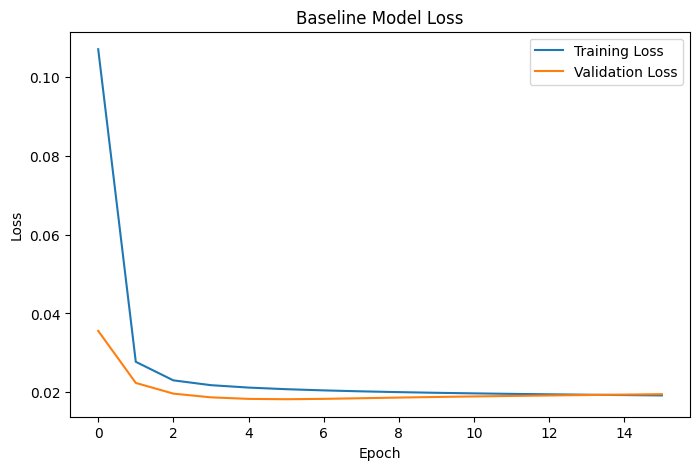

In [79]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


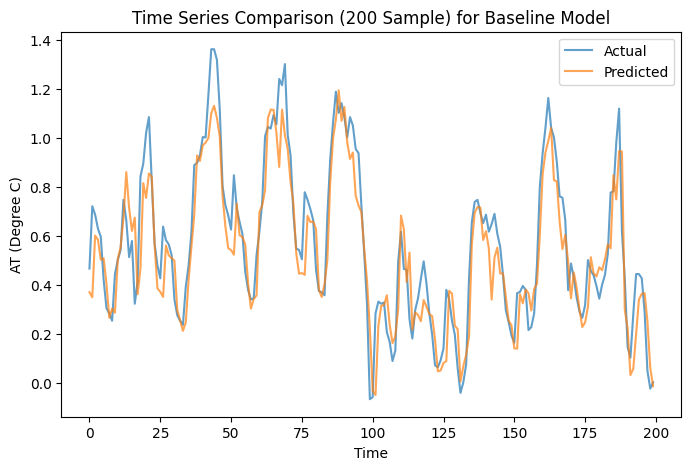

In [80]:
y_pred_base_unscaled = rs_y.inverse_transform(base_model.predict(x_test))

plt.figure(figsize=(8, 5))
sample_size = min(200, len(y_test))
plt.plot(y_test[:sample_size], label='Actual', alpha=0.7)
plt.plot(y_pred_base_unscaled[:sample_size], label='Predicted', alpha=0.7)
plt.title('Time Series Comparison (200 Sample) for Baseline Model')
plt.xlabel('Time')
plt.ylabel('AT (Degree C)')
plt.legend()

## Modified Model

In [81]:
modified_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=input_shape),
    Dropout(0.2),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

modified_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae'])

modified_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 5, 128)         │        77,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,833 (503.25 KB)

 Trainable params: 128,833 (503.25 KB)

 Non-trainable params: 0 (0.00 B)

Hyperparameter Tuning for Learning Rate

In [82]:
learning_rates = [0.001, 0.0005, 0.0001]
results = {}
best_model = None
min_test_mse = float('inf')

for lr in learning_rates:
    tf.keras.backend.clear_session()
    modified_model =  Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
        ])

    modified_model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae'])

    history_modified = modified_model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1)

    y_pred_modified = modified_model.predict(x_test)
    loss = mean_squared_error(y_test, y_pred_modified)
    mae = mean_absolute_error(y_test, y_pred_modified)
    r2 = r2_score(y_test, y_pred_modified)

    results[lr] = {
        'MSE': loss,
        'MAE': mae,
        'R2' : r2,
        'history': history_modified
    }
    print(f"Learning rate: {lr} | MSE: {loss:.5f} | MAE: {mae:.5f} | R2: {r2:.5f}")

    if loss < min_test_mse:
        min_test_mse = loss
        best_model = modified_model
        best_lr = lr

if best_model:
    print(f"Best learning rate untuk model LSTM yang sudah dimodifikasi: {best_lr}")

Epoch 1/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - loss: 0.0864 - mae: 0.2006 - val_loss: 0.0208 - val_mae: 0.1098
Epoch 2/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0273 - mae: 0.1124 - val_loss: 0.0220 - val_mae: 0.1141
Epoch 3/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0246 - mae: 0.1039 - val_loss: 0.0191 - val_mae: 0.1044
Epoch 4/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0230 - mae: 0.1000 - val_loss: 0.0169 - val_mae: 0.0961
Epoch 5/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0223 - mae: 0.0977 - val_loss: 0.0174 - val_mae: 0.0986
Epoch 6/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0216 - mae: 0.0962 - val_loss: 0.0173 - val_mae: 0.0982
Epoch 7/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0205 - mae: 0.0939 - val_loss: 0.0181 - val_mae: 0.1008
Epoch 8/100
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0202 - mae: 0.0932 - val_loss: 0.0173 - val_mae: 0.0982
Epoch 9/100
1182

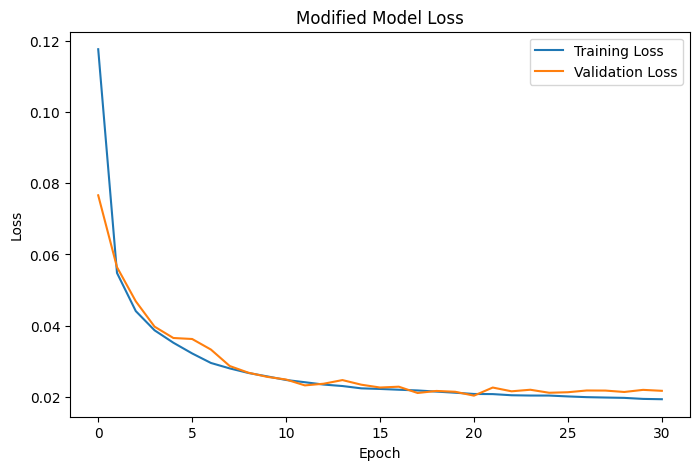

In [83]:
plt.figure(figsize=(8, 5))
plt.plot(history_modified.history['loss'], label='Training Loss')
plt.plot(history_modified.history['val_loss'], label='Validation Loss')
plt.title('Modified Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


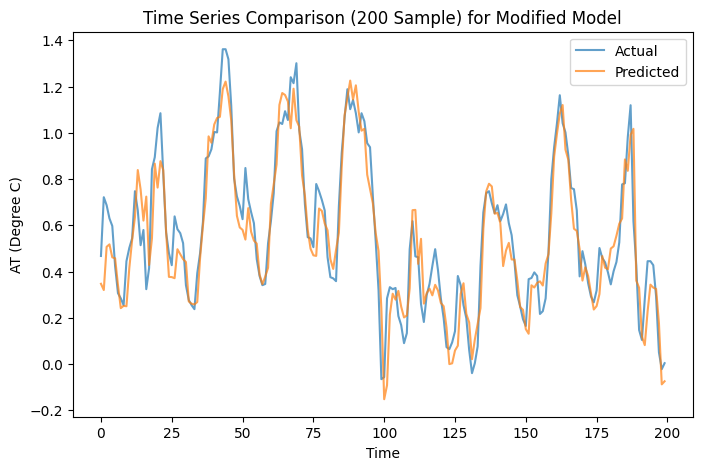

In [84]:
y_pred_modified_unscaled = rs_y.inverse_transform(best_model.predict(x_test))
y_test_unscaled = rs_y.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(8, 5))
sample_size = min(200, len(y_test))
plt.plot(y_test[:sample_size], label='Actual', alpha=0.7)
plt.plot(y_pred_modified_unscaled[:sample_size], label='Predicted', alpha=0.7)
plt.title('Time Series Comparison (200 Sample) for Modified Model')
plt.xlabel('Time')
plt.ylabel('AT (Degree C)')
plt.legend()

# **Conclusion**

In [85]:
modified_mse = mean_squared_error(y_test_unscaled, y_pred_modified_unscaled)
modified_mae = mean_absolute_error(y_test_unscaled, y_pred_modified_unscaled)
modified_r2 = r2_score(y_test_unscaled, y_pred_modified_unscaled)

base_mse = mean_squared_error(y_test_unscaled, y_pred_base_unscaled)
base_mae = mean_absolute_error(y_test_unscaled, y_pred_base_unscaled)
base_r2 = r2_score(y_test_unscaled, y_pred_base_unscaled)

In [86]:
comparison_data = {
    'Model': ['Baseline Model', f'Modified Model (LR={best_lr})'],
    'MSE': [base_mse, modified_mse],
    'MAE': [base_mae, modified_mae],
    'R2 Score': [base_r2, modified_r2]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

,Model,MSE,MAE,R2 Score
0,Baseline Model,0.018314,0.104998,0.915106
1,Modified Model (LR=0.001),0.014047,0.091934,0.934884


Berdasarkan hasil evaluasi, dapat diketahui bahwa nilai MSE dari 0.018314 (baseline) ke 0.014047 (modified) dan MAE dari 0.104998 (baseline) ke 0.091934 (modified) menunjukkan bahwa model yang telah dimodifikasi memberikan hasil prediksi yang lebih akurat dan mendekati nilai 0. Selain itu, untuk nilai R2-nya, dapat diketahui bahwa Modified Model memiliki nilai yang lebih tinggi dan mendekati 1, yaitu sebesar 0.934884. Hal ini dapat diaratikan bawa kemampuan Modified Model lebih unggul dalam menjelaskan variabilitas data.

Dapat disimpulkan bahwa Modified Model (dengan best learning rate: 0.001) mengungguli Baseline Model (learning rate juga 0.001) di ketiga metric tersebut dan merupakan model yang lebih baik.

Keberhasilan Modified Model untuk mengungguli Baseline Model ini kemungkinan besar dikarenakan oleh pembuatan arsitektur model yang lebih kompleks, yaitu menambahkan Dropout dan Dense layer.